<a href="https://colab.research.google.com/github/danielwhitt/FATE/blob/main/oscar_parcels_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install podaac-data-subscriber
# replace login and password with earth datalogin and password
!touch /root/.netrc
# replace your_uid with your nasa earth data id and replace your_password with your nasa earth data password
!echo "machine urs.earthdata.nasa.gov login  your_uid password your_password" >> /root/.netrc

!chmod 0600 /root/.netrc

In [ ]:
# download the last 30 days of OSCAR near real time surface currents, global files 1/4 degree
# change the start and end dates to the last 30 days
!podaac-data-downloader -c OSCAR_L4_OC_NRT_V2.0 -d ./data --start-date 2024-04-01T00:00:00Z --end-date 2024-05-01T00:00:00Z -e .nc


[2024-05-03 22:04:37,457] {podaac_data_downloader.py:317} INFO - Found 30 total files to download
[2024-05-03 22:04:40,836] {podaac_data_downloader.py:358} INFO - 2024-05-03 22:04:40.836767 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240430.nc
[2024-05-03 22:04:42,224] {podaac_data_downloader.py:358} INFO - 2024-05-03 22:04:42.224068 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240429.nc
[2024-05-03 22:04:43,194] {podaac_data_downloader.py:358} INFO - 2024-05-03 22:04:43.194110 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240428.nc
[2024-05-03 22:04:44,194] {podaac_data_downloader.py:358} INFO - 2024-05-03 22:04:44.194652 SUCCESS: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240427.nc
[2024-

In [ ]:
# 2002 data for comparison with globcurrent option? This takes 8 minutes, so comment out for now.
#!podaac-data-downloader -c OSCAR_L4_OC_FINAL_V2.0 -d ./data --start-date 2002-01-01T00:00:00Z --end-date 2003-01-01T00:00:00Z -e .nc

In [ ]:
# download noaa buoy trajectory data
import urllib
urllib.request.urlretrieve("https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/OSMC_RealTime.nc?platform_type%2Ctime%2Clatitude%2Clongitude%2Cplatform_code&platform_type=%22DRIFTING%20BUOYS%20(GENERIC)%22&time%3E=2024-03-15T00%3A00%3A00Z&latitude%3E=-15&latitude%3C=15&longitude%3E=-180&longitude%3C=-90&orderBy(%22platform_code%2Ctime%22)","/content/buoydatafile.nc")


('/content/buoydatafile.nc', <http.client.HTTPMessage at 0x79430217b1c0>)

In [ ]:
!pip install parcels
!pip install cftime
!pip install cgen
!pip install trajan
!pip install zarr
!pip install pymbolic

import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)

import parcels as ps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.6/144.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15821 sha256=55fce91f1d633d18464687a5096f5939853d3591b34117db99224e1c7aeb6e59
  Stored in directory: /root/.cache/pip/wheels/e6/64/97/7637a7ca9c143c1eaaeeb048c6e772677a68eb4d8695a9cc2a
Successfully built cgen
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.1 MB/s eta 0:00:00

In [ ]:
ds=xr.open_mfdataset("/content/data/oscar_currents_nrt_202404*.nc",decode_times=False)
ds['time'] = xr.coding.times.decode_cf_datetime(ds['time'], calendar='gregorian',units='days since 1990-01-01')
#ds.to_netcdf(path="/content/data/oscar_currents_nrt_20240411_greg.nc")



In [ ]:
ds

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 30)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2024-04-01 2024-04-02 ... 2024-04-30
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-04-01T00:00:00
    time_coverage_end:          2024-04-01T23:59:59
    date_created:               2024-05-03

In [ ]:
variables = {
    "U": "u",
    "V": "v",
}
dimensions = {"time": "time", "lat": "lat", "lon": "lon"}


In [ ]:

fieldset=FieldSet.from_xarray_dataset(ds.transpose("time", "latitude", "longitude"),variables,dimensions,allow_time_extrapolation=True)


In [ ]:
dsbuoy=xr.open_mfdataset('/content/buoydatafile.nc')
dsbuoy


<xarray.Dataset>
Dimensions:        (row: 5294)
Dimensions without coordinates: row
Data variables:
    platform_type  (row) object dask.array<chunksize=(5294,), meta=np.ndarray>
    time           (row) datetime64[ns] dask.array<chunksize=(5294,), meta=np.ndarray>
    latitude       (row) float64 dask.array<chunksize=(5294,), meta=np.ndarray>
    longitude      (row) float64 dask.array<chunksize=(5294,), meta=np.ndarray>
    platform_code  (row) object dask.array<chunksize=(5294,), meta=np.ndarray>
Attributes: (12/29)
    cdm_altitude_proxy:        observation_depth
    cdm_data_type:             Point
    Conventions:               COARDS, CF-1.6, Unidata Dataset Discovery v1.0
    Easternmost_Easting:       -90.0002
    featureType:               Point
    geospatial_lat_max:        12.0508
    ...                        ...
    subsetVariables:           platform_type
    summary:                   OSMC flattened observations from GTS, providin...
    time_coverage_end:         2024-05-03T20:00:00Z
    time_coverage_start:       2024-03-15T00:00:00Z
    title:                     OSMC flattened observations from GTS
    Westernmost_Easting:       -179.9976

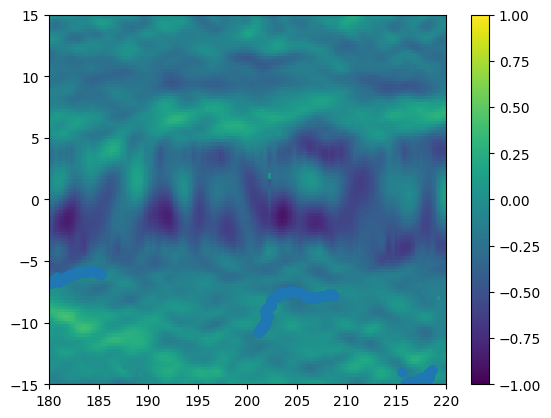

In [ ]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[5, :, :])
#plt.xlabel("Zonal distance [m]")
#plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.clim(-1.0,1.0)

plt.scatter(360+dsbuoy.longitude,dsbuoy.latitude)

plt.xlim(180,220)
plt.ylim(-15,15)
plt.clim(-1.0,1.0)


plt.show()


In [ ]:
pset2 = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=10,  # releasing 5 particles
    start=(206, -8),  # releasing on a line: the start longitude and latitude
    finish=(210, -8),  # releasing on a line: the end longitude and latitude
)
output_file = pset2.ParticleFile(
    name="OSCARparticlesOBS.zarr", outputdt=timedelta(hours=1)
)
pset2.execute(
    AdvectionRK4,
    runtime=timedelta(days=30),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticlesOBS.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticlesOBS.zarr.


100%|██████████| 2592000.0/2592000.0 [01:06<00:00, 38818.54it/s]


In [ ]:
pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(197, 3),  # releasing on a line: the start longitude and latitude
    finish=(197, 9),  # releasing on a line: the end longitude and latitude
)


In [ ]:
output_file = pset.ParticleFile(
    name="OSCARparticles163.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles163.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles163.zarr.


100%|██████████| 864000.0/864000.0 [00:16<00:00, 51098.86it/s] 


In [ ]:
pset1 = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=50,  # releasing 5 particles
    start=(199, 3),  # releasing on a line: the start longitude and latitude
    finish=(199, 9),  # releasing on a line: the end longitude and latitude
)
output_file = pset1.ParticleFile(
    name="OSCARparticles161.zarr", outputdt=timedelta(hours=1)
)
pset1.execute(
    AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in OSCARparticles161.zarr.


INFO:parcels.tools.loggers:Output files are stored in OSCARparticles161.zarr.


100%|██████████| 864000.0/864000.0 [00:10<00:00, 79659.74it/s]


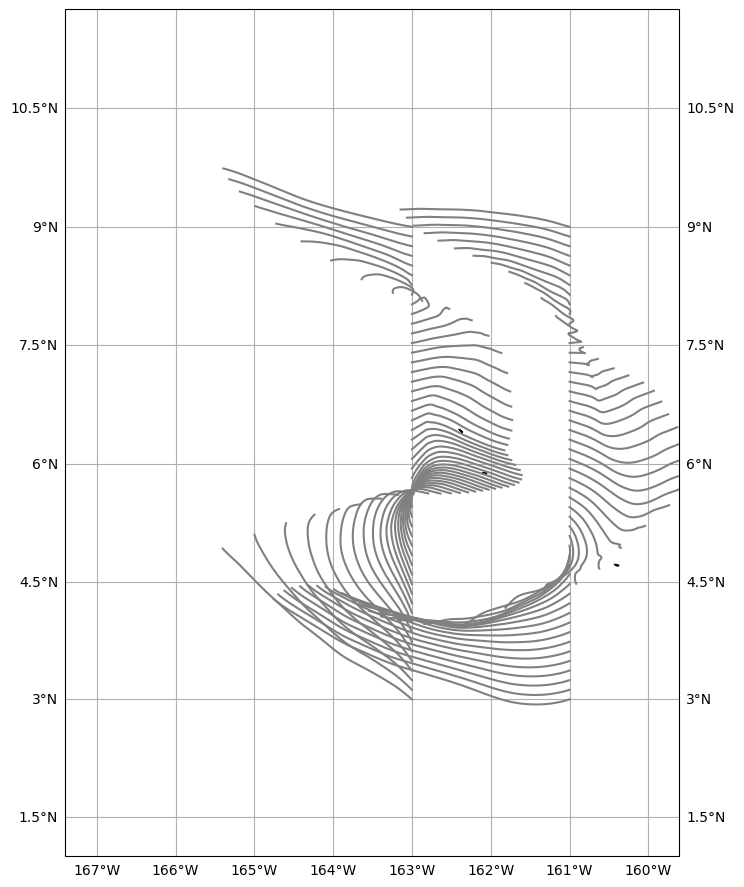

In [51]:
ds = xr.open_zarr("OSCARparticles163.zarr")
ds.traj.plot(margin=2)
ds1 = xr.open_zarr("OSCARparticles161.zarr")
ds1.traj.plot(margin=1)
plt.show()




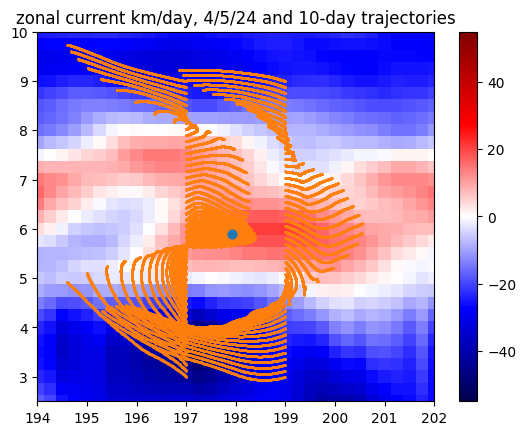

In [92]:
import seaborn as sns
from matplotlib.colors import ListedColormap
colors = sns.mpl_palette('Paired',n_colors=8)
cmap   = sns.mpl_palette('Paired',n_colors=8,as_cmap=True)
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[5, :, :]*86.4)
plt.set_cmap('seismic')
plt.colorbar()
plt.xlim(194,202)
plt.ylim(2.5,10)
plt.clim(-55,55)
plt.title('zonal current km/day, 4/5/24 and 10-day trajectories')

plt.scatter(ds.lon[:,:],ds.lat[:,:],c='#ff7f0e',s=4,marker='.')

plt.scatter([197.92],[5.9],s=40,marker='o')


plt.scatter(ds1.lon[:,:],ds1.lat[:,:],s=4,c='#ff7f0e',marker='.')

plt.show()


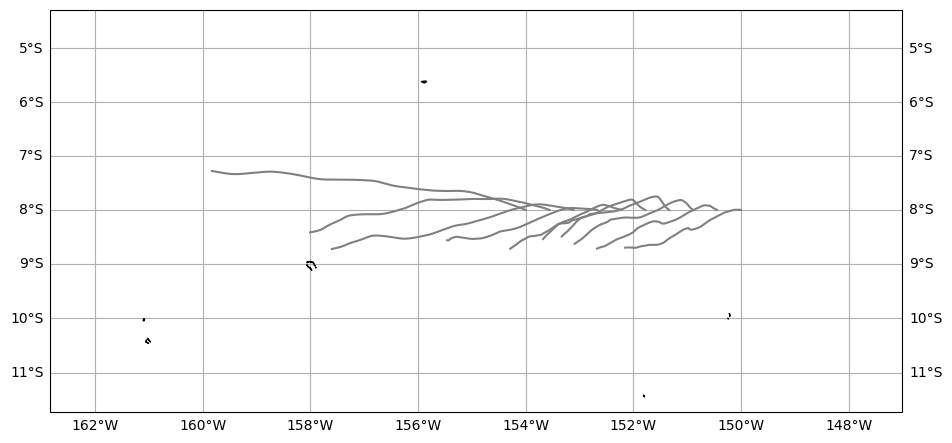

In [ ]:
ds2 = xr.open_zarr("OSCARparticlesOBS.zarr")
ds2.traj.plot(margin=3)


plt.show()
# compare with the drifter track above (205 = 155 deg W)
# going in the right direction at least...

In [30]:
#urllib.request.urlretrieve("http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_bathymetry_all.zip")
#!gunzip ./data/ne_10m_bathymetry_all.zip
#!ls ./data

gzip: ./data/ne_10m_bathymetry_all.zip: unknown suffix -- ignored
ne_10m_bathymetry_all.zip	oscar_currents_nrt_20240411.nc	oscar_currents_nrt_20240422.nc
oscar_currents_nrt_20240401.nc	oscar_currents_nrt_20240412.nc	oscar_currents_nrt_20240423.nc
oscar_currents_nrt_20240402.nc	oscar_currents_nrt_20240413.nc	oscar_currents_nrt_20240424.nc
oscar_currents_nrt_20240403.nc	oscar_currents_nrt_20240414.nc	oscar_currents_nrt_20240425.nc
oscar_currents_nrt_20240404.nc	oscar_currents_nrt_20240415.nc	oscar_currents_nrt_20240426.nc
oscar_currents_nrt_20240405.nc	oscar_currents_nrt_20240416.nc	oscar_currents_nrt_20240427.nc
oscar_currents_nrt_20240406.nc	oscar_currents_nrt_20240417.nc	oscar_currents_nrt_20240428.nc
oscar_currents_nrt_20240407.nc	oscar_currents_nrt_20240418.nc	oscar_currents_nrt_20240429.nc
oscar_currents_nrt_20240408.nc	oscar_currents_nrt_20240419.nc	oscar_currents_nrt_20240430.nc
oscar_currents_nrt_20240409.nc	oscar_currents_nrt_20240420.nc	OSCAR_L4_OC_NRT_V2.0.citation.txt
oscar_

In [49]:
import urllib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import seaborn as sns
from glob import glob



colors = sns.mpl_palette('Paired',n_colors=8)
cmap   = sns.mpl_palette('Paired',n_colors=8,as_cmap=True)

shp_dict = {}
files = glob('./data/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei


depths = [d for d in shp_dict.keys()][::-1]

colors = sns.mpl_palette('Paired',n_colors=8)
cmap   = sns.mpl_palette('Paired',n_colors=8,as_cmap=True)


fig = plt.figure(figsize=(13,13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-20, 45, -52, -16), crs=ccrs.PlateCarree())

i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1
# ax.set_facecolor('grey')
# ax.add_feature(cart.feature.LAND,color='grey')
ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='LAND',scale='110m'),color='grey',
              zorder=0)
# ax.coastlines(lw=1,resolution='110m')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.92,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
#cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],ticks=-np.array(depths).astype(int),spacing='proportional',extend='neither',label='Depth (m)')


# ax.plot(sampling_locs['longitude'],
#            sampling_locs['latitude'],
#            zorder=5, color='yellow' )
# ax.scatter(sampling_locs['longitude'],
#            sampling_locs['latitude'],
#            zorder=5, color='yellow', label='Sampling locs.')
# ax.legend(loc='upper left', shadow=True, fontsize=12)




Error in callback <function _draw_all_if_interactive at 0x794303019000> (for post_execute):


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_LAND.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


HTTPError: HTTP Error 404: Not Found

HTTPError: HTTP Error 404: Not Found

<Figure size 1300x1300 with 2 Axes>